## Entrée Chicago Recommendation

## Introduction
Le jeu de données contient des recommandations de restaurants interactives pour chaque utilisateur. L'utilisateur peut interagir avec chaque nouvelle proposition de recommandation. L'objectif est, à partir de la séquence de restaurants observée et des interactions réalisées par l'utilisateur, de prédire le restaurant désiré. J'ai choisi de seulement prédire le choix final, et pas les séquences intermédiaires, afin de ne pas apprendre le système de recommandation en place. Cela permet de réduire l'effet de biais. Mon objectif est de réaliser la meilleure prédiction afin de satisfaire au mieux l'utilisateur. Ma métrique d'évaluation se basera sur la qualité de la recommandation réalisée à la vue du parcours de l'utilisateur.

En résumé, nous devons prédire une classe à partir d'une séquence. La solution que j'ai retenue est une approche type Deep Learning avec l'utilisation d'un Réseau de Neurones Récurrents.




## Préparation des données pour l'entrainement
### Chargement des données et packages

In [1]:
# chargement des packages
import os
import re
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import Dropout,concatenate,Embedding,LSTM,Input, Dense,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
# indication du positionnement des données dans l'arborescence
session_dir = './entree/session'
data_dir = './entree/data'

### Extraction des données de session

In [2]:
# extraction des données de session

labels = [] # End point

# je lis les fichiers et je remplis les tableaux
list_session = os.listdir(session_dir)
for file in filter(lambda x:"session" in x, list_session):
    with open(os.path.join(session_dir,file)) as f:
        lines = f.read().splitlines()
        for line in lines:
            content = line.split('\t')
            label = int(content[-1])
            # je supprime les séquences sans label qui n'apporte rien dans mon approche du problème
            if label == -1:
                continue
            labels.append(label)


Après collecte des données, nous avons 618 classes en tout, avec certaines peu représentées. Nous les avons gardées lors de l'apprentissage. Soyons conscients qu'elles détérioreront la qualité de nos prédictions.

count    618.000000
mean      72.135922
std       92.213572
min        1.000000
25%       16.000000
50%       44.500000
75%       92.000000
max      773.000000
dtype: float64

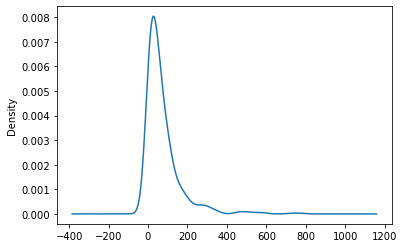

In [3]:
from collections import Counter

size_dict = len(Counter(labels).keys())
counts = list(Counter(labels).values())
pd.Series(counts).plot(kind="kde")
pd.Series(counts).describe()

Désormais, éliminons les labels pour lesquels on a peu de données. Ils pénaliseront la performance de notre modèle. On gardera seulement les labels avec plus de 100 recommendations.

In [4]:
no_keep_labels = []
for x,y in Counter(labels).items():
    if y<70:
        no_keep_labels.append(x)

In [5]:
# extraction des données de session

restaurant_seq = [] # sequence de Rated restaurant1,..,Rated restaurantN
browser_seq = [] # sequence interaction utilisateur
labels = [] # End point
entry = [] # Entry point

def pick_number(x):
    """ Function extracting from a string numerical values
    """
    return int(re.sub("[^0-9]", "", x))

# je lis les fichiers et je remplis les tableaux
list_session = os.listdir(session_dir)
for file in filter(lambda x:"session" in x, list_session):
    print(file)
    with open(os.path.join(session_dir,file)) as f:
        lines = f.read().splitlines()
        for line in lines:
            content = line.split('\t')
            label = int(content[-1])
            # je supprime les séquences sans label qui n'apporte rien dans mon approche du problème
            if label == -1 or label in no_keep_labels:
                continue
            labels.append(label)
            entry.append(content[2])
            restaurant_seq.append(list(map(pick_number, content[3:-1])))
            browser_seq.append(list(map(lambda x:x[-1], content[3:-1])))

session.1996-Q3
session.1996-Q4
session.1997-Q1
session.1997-Q2
session.1997-Q3
session.1997-Q4
session.1998-Q1
session.1998-Q2
session.1998-Q3
session.1998-Q4
session.1999-Q1
session.1999-Q2


count    208.000000
mean     159.543269
std      113.828662
min       70.000000
25%       92.000000
50%      115.500000
75%      178.250000
max      773.000000
dtype: float64

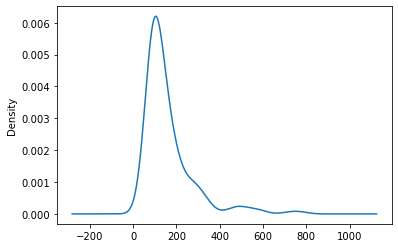

In [6]:
from collections import Counter

size_dict = len(Counter(labels).keys())
counts = list(Counter(labels).values())
pd.Series(counts).plot(kind="kde")
pd.Series(counts).describe()

In [7]:
len(counts)

208

### Extraction des features pour chaque restaurant

Ici, nous allons stocker dans _restaurant_encoding_ pour chaque ville et restaurant la liste des features. Nous pourrons l'utiliser par la suite pour réaliser l'encodage de chaque restaurant dans la séquence.

In [8]:
city_to_code = {'atlanta':'A','boston':'B','chicago':'C','los_angeles':'D',
                'new_orleans':'E','new_york':'F','san_francisco':'G',
                'washington_dc':'H'
               }

with open(os.path.join(data_dir,'features.txt')) as f:
    lines = f.read().splitlines()
    len_features = len(lines)

list_data = os.listdir(data_dir)
restaurant_encoding = dict()
for file in filter(lambda x:not ("feature" in x or "README" in x), list_data):
    print(file[:-4])
    restaurant_encoding[city_to_code[file[:-4]]] = dict()
    with open(os.path.join(data_dir,file)) as f:
        lines = f.read().splitlines()
        for line in lines:
            content = line.split('\t')
            restaurant_encoding[city_to_code[file[:-4]]][int(content[0])] = [int(x) for x in content[2].split()]

atlanta
boston
chicago
los_angeles
new_orleans
new_york
san_francisco
washington_dc


### Création des tables de correspondances

Les index des restaurants donnés n'étant pas contigus, nous créons deux tables _restaurant_idx_ et _idx_restaurant_ afin de travailler une table d'index contigus. Et, nous créons une table d'encodage _encoding_browser_ pour les interactions utilisateurs. On réalise aussi des tables de correspondances pour les labels : _label_idx_ et _idx_label_.

In [9]:
# create restaurant_idx and idx_restaurant
restaurant = set()
for seq in restaurant_seq:
    for x in seq:
        restaurant.add(x)

restaurant_idx = dict()
idx_restaurant = dict()
for i, w in enumerate(restaurant):
    restaurant_idx[w] = i
    idx_restaurant[i] = w
len_emb = len(restaurant)
browser=set()
for seq in browser_seq:
    for x in seq:
        browser.add(x)

encoding_browser = dict()
decoding_browser = dict()
for i, w in enumerate(browser):
    encoding_browser[w] = i
    decoding_browser[i] = w
tweak_size = len(browser)

label_for_idx = set()
for label in labels:
    label_for_idx.add(label)

label_idx = dict()
idx_label = dict()
for i, w in enumerate(label_for_idx):
    label_idx[w] = i
    idx_label[i] = w


### Création des séquences
Dans cette partie, nous allons créer une séquence _idx_seq_ de tables de features à partir de la séquence de restaurants _restaurant_seq_ et _entry_ le cas échéant. Et, on crée la séquence _browser_encoded_seq_ contenant la séquence encodée des interactions utilisateurs.

In [10]:
# map sequences with restaurant_idx
idx_seq = []
max_seq = 0

for i,seq in enumerate(restaurant_seq):
    tmp = list()
    if entry[i]!='0':
        city = entry[i][-1]
        code = int(entry[i][:-1])
        tmp.append(restaurant_encoding[city][code])
    for x in map(lambda x:restaurant_encoding["C"][x], seq):
        tmp.append(x)
    idx_seq.append(tmp)
    max_seq = max(max_seq, len(tmp))

browser_encoded_seq = []
for seq in browser_seq:
    browser_encoded_seq.append(list(map(lambda x:encoding_browser[x], seq)))

Ici, on réalise le OneHotEncoding des séquences concaténées _idx_seq_ et _browser_encoded_seq_ créées précédemment. Ce seront les données d'entrées qui nourriront notre modèle. Elles sont stockées dans _encoded_seq_. Et, on va remplir _y_ pour préparer l'entraînement en réalisant le OneHotEncoding. Aussi, dans _restaurant_entry_seq_, je rajoute la séquence des restaurants afin de pouvoir réaliser une embedding type word2vec dessus.

In [11]:
restaurant_entry_seq = []
for i,seq in enumerate(restaurant_seq):
    tmp = list()
    if entry[i]!='0':
        tmp.append(0)
    for x in map(lambda x:restaurant_idx[x], seq):
        tmp.append(x)
    restaurant_entry_seq.append(tmp)

encoded_seq = []
for seq1, seq2 in zip(idx_seq,browser_encoded_seq):
    a= np.zeros((len(seq1), len_features+tweak_size), dtype=np.int8)
    for i, x in enumerate(seq1):
        a[i, x] = 1
    for i, x in enumerate(seq2):
        a[i, x+len_features] = 1
    encoded_seq.append(list(a))
    
idx_lab = []
for lab in labels:
    idx_lab.append(label_idx[lab])
y = np.zeros((len(idx_lab), size_dict), dtype=np.int8)

Pour les données d'entrée du modèle __X__ et __X_emb__, on réalise un padding des séquences. On fixe la longueur de la séquence __max_seq__ à 60 correspondant à la longueur maximale des séquences. Ceci est un hyperparamètre qu'il s'agirait d'optimiser afin d'améliorer les performances.

In [12]:
y.shape

(33185, 208)

In [13]:
#max_seq = 60
X = pad_sequences(encoded_seq, maxlen=max_seq)
X_emb = pad_sequences(restaurant_entry_seq, maxlen=max_seq)

for idx, lab_idx in enumerate(idx_lab):
    y[idx, lab_idx] = 1

## Modèle Deep Learning du sytème de recommendation

On crée naturellement notre jeu d'entraînement et de test.

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, X_emb_train, X_emb_test, y_train, y_test = train_test_split(X, X_emb, y, test_size=0.2, random_state=42)


### Création du modèle

In [15]:
embedding_size = 128
dense_size = 64
def create_model(max_seq, embedding_size, dense_size):
    inp = Input(shape=(max_seq,len_features+tweak_size))
    inp_emb = Input(shape=(max_seq))
    emb = Embedding(
        input_dim=len_emb+1,
        output_dim=embedding_size,
        weights=None,
        trainable=True)(inp_emb)
#    out1 = Dense(embedding_size, activation='relu')(inp)
    merged = concatenate([(emb),(inp)])
#    out2 = Dense(embedding_size, activation='relu')(merged)
#    dropout1 = Dropout(0.5)(out2)
#    batchn = BatchNormalization()(dropout1)
    lstm1 = LSTM(
            embedding_size, dropout=0.1,return_sequences=True,
            recurrent_dropout=0.1)(merged)
    lstm2 = LSTM(
            embedding_size, return_sequences=False, dropout=0.1,
            recurrent_dropout=0.1)(lstm1)
    dense1 = Dense(dense_size, activation='relu')(lstm2)
    batchn2 = BatchNormalization()(dense1)
    dropout2 = Dropout(0.5)(batchn2)
    output = Dense(size_dict, activation='softmax')(dropout2)

    model = Model(inputs= [inp, inp_emb], outputs=output)
    return model

model = create_model(max_seq, embedding_size, dense_size)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# emplacement du fichier de checkpoint
filepath="weights.best.hdf5"
# Chargement du modèle pré-entrainé 
# model = load_model(filepath)

Le modèle est constitué d'une couche dense permettant de capturer les interactions entre les features du restaurant et les interactions utilisateurs. On réduit à _embedding_size_ qui permet de réduire la dimension du problème et de capturer les informations essentielles. S'en suit la couche LSTM, qui elle permet de traiter la séquence et extraire les informations pertinentes au fur et à mesure des interactions. Puis, deux couches denses à nouveau, qui sont chargées de réaliser la classification.

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 59, 128)      79872       input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 59, 264)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 59, 392)      0           embedding[0][0]                  
                                                                 input_1[0][0]                

Ici, on peut voir une représentation graphique du modèle avec en entrée de la couche dense la concaténation des vecteurs OneHotEncoding des actions utilisateurs et des caractéristiques restaurants, et en entrée de l'embedding l'id des restaurants.

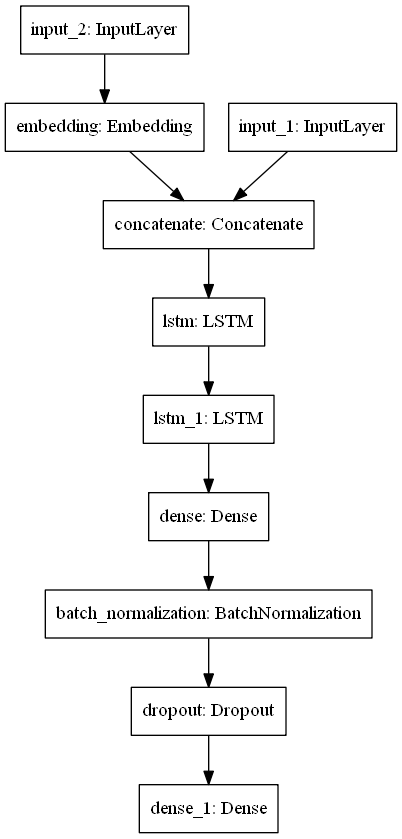

In [18]:
plot_model(model, to_file='output/model.png')


Ici, je charge une classe afin de tracer l'évolution de l'entraînement au fur à mesure des epochs.

In [19]:
class TrainingPlot(Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.val_losses = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:

            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")

            # Plot train loss, val loss  against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            # Make sure there exists a folder called output in the current directory
            # or replace 'output' with whatever direcory you want to put in the plots
            plt.savefig('output/Epoch-{}.png'.format(epoch))
#             plt.show()
            plt.close()

On entraîne le modèle:

In [20]:
# checkpoint qui permet de stocker le meilleur modèle
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callback qui permet de tracer l'évolution de l'entrainement
plot_losses = TrainingPlot()
callbacks_list = [checkpoint, plot_losses]

epochs = 20

model.fit([X_train,X_emb_train], y_train, epochs= epochs, validation_data=([X_test, X_emb_test], y_test), callbacks=callbacks_list)

Train on 26548 samples, validate on 6637 samples
Epoch 1/20
26528/26548 [============================>.] - ETA: 0s - loss: 4.1082 - accuracy: 0.1137
Epoch 00001: val_accuracy improved from -inf to 0.22857, saving model to weights.best.hdf5
26548/26548 [==============================] - 264s 10ms/sample - loss: 4.1078 - accuracy: 0.1137 - val_loss: 2.8813 - val_accuracy: 0.2286
Epoch 2/20
26528/26548 [============================>.] - ETA: 0s - loss: 2.9148 - accuracy: 0.2358
Epoch 00002: val_accuracy improved from 0.22857 to 0.30601, saving model to weights.best.hdf5
26548/26548 [==============================] - 223s 8ms/sample - loss: 2.9145 - accuracy: 0.2359 - val_loss: 2.4220 - val_accuracy: 0.3060
Epoch 3/20
26528/26548 [============================>.] - ETA: 0s - loss: 2.6108 - accuracy: 0.2883
Epoch 00003: val_accuracy improved from 0.30601 to 0.34579, saving model to weights.best.hdf5
26548/26548 [==============================] - 214s 8ms/sample - loss: 2.6108 - accuracy: 0.2

On visualise l'entraînement:

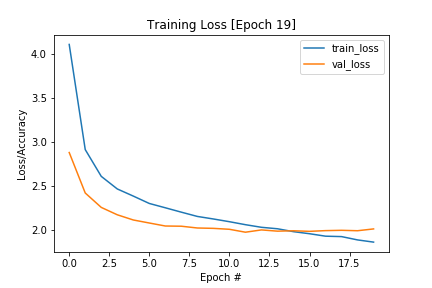

In [21]:
from IPython.display import Image
Image(filename='output/Epoch-{}.png'.format(epochs-1))

25 epochs seulement auraient suffi.

## Evaluation du modèle

Enfin, on évalue le modèle en regardant le rang, dans notre prédiction, du restaurant choisi par l'utilisateur. On voit que le quantile à 50% a un rang de 3.

In [22]:
# Chargement du meilleur modèle  
model = load_model(filepath)

In [23]:
y_pred = model.predict([np.asarray(X_test, dtype=np.float32), np.asarray(X_emb_test, dtype=np.float32)])   
rank = []
for i in range(len(y_test)):
    true_label=np.argmax(y_test[i])
    pred_label=np.argmax(y_pred[i])
    rank.append((size_dict-int(np.where(np.argsort(y_pred[i])== true_label)[0])))
    
pd.Series(rank).describe()

count    6637.000000
mean        5.662799
std        12.967487
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       204.000000
dtype: float64

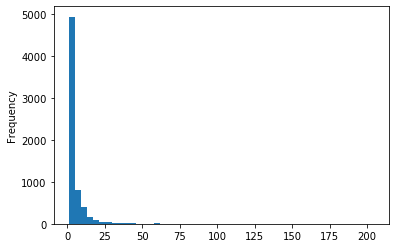

In [24]:
pd.Series(rank).plot.hist(bins=50)

Sur 339 classes, on a un quantile du rang à 95% de 28. Le classifieur performe plutôt bien.

In [25]:
np.quantile(rank, 0.95)

18.0

## Perspectives

Pour la suite, nous pourrions nous intéresser au nettoyage des données, notamment la suppression d'outliers avec des classes peu fréquentes. Aussi, nous pourrions réaliser une étude hyper-paramétrique de notre réseau de neurones afin d'améliorer ses performances, en jouant sur les paramètres_ max_seq_, _embedding_size_ et _dense_size_ , mais aussi sur l'architecture en rajoutant des couches. Une couche intéressante à rajouter est une couche d' _Embedding_ en entrée. J'ai commencé à regarder cette approche et elle semble améliorer la performance.